In [11]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def smote_data(self, x_data, y_data):
        from collections import Counter
        from imblearn.over_sampling import SMOTE
        sm = SMOTE()
        X_res, y_res = sm.fit_sample(x_data, y_data)
        print('Resampling the data with SMOTE. . .')
        print('Resampled training dataset shape {}'.format(Counter(y_res)))

        return X_res, y_res
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        self.data_cols = data.columns
        
        X = data.loc[:, data.columns != 'Class']
        y = data.loc[:, data.columns == 'Class']

        X_res, y_res = self.smote_data(X,y)
        print (X_res, y_res)
        
        data_fraud = pd.DataFrame(X_res)
        data_fraud['Class'] = y_res
        
        data_fraud.columns = self.data_cols
        
        # Take only the fraud examples
        data_fraud = data_fraud.loc[data_fraud['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values

        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        counter = 0
        
        for epoch in range(epochs):

            self.discriminator.trainable = True
            

         # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)


            # Train the discriminator
            X = np.concatenate((imgs,gen_imgs))
            y = np.zeros([len(imgs)+len(gen_imgs),2])
            y[0:len(imgs),1] = 1
            y[len(imgs):,0] = 1
            d_loss = self.discriminator.train_on_batch(X, y)
        #             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
        #             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
        #             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)
            valid_y = np.zeros([batch_size,2])
            valid_y[:,1] = 1
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1.4-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (284315, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1.4-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

Resampling the data with SMOTE. . .
Resampled training dataset shape Counter({0: 284315, 1: 284315})
[[  0.00000000e+00  -1.35980713e+00  -7.27811733e-02 ...,   1.33558377e-01
   -2.10530535e-02   1.49620000e+02]
 [  0.00000000e+00   1.19185711e+00   2.66150712e-01 ...,  -8.98309914e-03
    1.47241692e-02   2.69000000e+00]
 [  1.00000000e+00  -1.35835406e+00  -1.34016307e+00 ...,  -5.53527940e-02
   -5.97518406e-02   3.78660000e+02]
 ..., 
 [  3.59316522e+04  -4.00167466e+00   4.47050287e+00 ...,   5.78611896e-01
    4.91408320e-01   8.05728630e+00]
 [  1.10173920e+05   1.11522023e+00   9.23037506e-01 ...,   2.65725227e-02
   -6.31178543e-02   1.58082270e+01]
 [  1.50734117e+05  -4.03911117e-01   1.38068997e+00 ...,   9.92083957e-02
    1.73317835e-01   5.37488788e+00]] [0 0 0 ..., 1 1 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 30)                0         
__

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:227: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.675878, acc.: 50.00%] [G loss: 0.602252]
(284315, 100)
(284315, 30)
1 [D loss: 0.656468, acc.: 59.38%] [G loss: 0.556093]
2 [D loss: 0.656163, acc.: 53.12%] [G loss: 0.522293]
3 [D loss: 0.670625, acc.: 46.88%] [G loss: 0.477294]
4 [D loss: 0.642732, acc.: 51.56%] [G loss: 0.436093]
5 [D loss: 0.658425, acc.: 51.56%] [G loss: 0.411613]
6 [D loss: 0.686350, acc.: 50.00%] [G loss: 0.412929]
7 [D loss: 0.680704, acc.: 50.00%] [G loss: 0.423377]
8 [D loss: 0.722506, acc.: 50.00%] [G loss: 0.446553]
9 [D loss: 0.697103, acc.: 50.00%] [G loss: 0.470282]
10 [D loss: 0.737404, acc.: 56.25%] [G loss: 0.516171]
11 [D loss: 0.718805, acc.: 54.69%] [G loss: 0.555711]
12 [D loss: 0.695211, acc.: 59.38%] [G loss: 0.630651]
13 [D loss: 0.722833, acc.: 46.88%] [G loss: 0.690220]
14 [D loss: 0.702072, acc.: 50.00%] [G loss: 0.787736]
15 [D loss: 0.667147, acc.: 62.50%] [G loss: 0.852508]
16 [D loss: 0.777377, acc.: 43.75%] [G loss: 0.967594]
17 [D loss: 0.696726, acc.: 57.81%] [G loss: 0.9

154 [D loss: 0.646080, acc.: 71.88%] [G loss: 0.833903]
155 [D loss: 0.642528, acc.: 75.00%] [G loss: 0.835151]
156 [D loss: 0.639215, acc.: 78.12%] [G loss: 0.807976]
157 [D loss: 0.645070, acc.: 70.31%] [G loss: 0.813260]
158 [D loss: 0.622428, acc.: 75.00%] [G loss: 0.823270]
159 [D loss: 0.589191, acc.: 84.38%] [G loss: 0.845964]
160 [D loss: 0.634558, acc.: 67.19%] [G loss: 0.824416]
161 [D loss: 0.600082, acc.: 76.56%] [G loss: 0.813924]
162 [D loss: 0.584409, acc.: 87.50%] [G loss: 0.812195]
163 [D loss: 0.627273, acc.: 75.00%] [G loss: 0.828409]
164 [D loss: 0.600363, acc.: 92.19%] [G loss: 0.791348]
165 [D loss: 0.615740, acc.: 71.88%] [G loss: 0.790686]
166 [D loss: 0.638967, acc.: 67.19%] [G loss: 0.810045]
167 [D loss: 0.654485, acc.: 64.06%] [G loss: 0.791781]
168 [D loss: 0.627135, acc.: 70.31%] [G loss: 0.821510]
169 [D loss: 0.655922, acc.: 64.06%] [G loss: 0.780771]
170 [D loss: 0.613802, acc.: 73.44%] [G loss: 0.793352]
171 [D loss: 0.591276, acc.: 82.81%] [G loss: 0.

308 [D loss: 0.591875, acc.: 73.44%] [G loss: 0.814532]
309 [D loss: 0.574300, acc.: 82.81%] [G loss: 0.833928]
310 [D loss: 0.548597, acc.: 89.06%] [G loss: 0.858613]
311 [D loss: 0.546791, acc.: 85.94%] [G loss: 0.882561]
312 [D loss: 0.547954, acc.: 87.50%] [G loss: 0.887408]
313 [D loss: 0.591064, acc.: 75.00%] [G loss: 0.873496]
314 [D loss: 0.565786, acc.: 78.12%] [G loss: 0.878369]
315 [D loss: 0.592631, acc.: 85.94%] [G loss: 0.899316]
316 [D loss: 0.559819, acc.: 79.69%] [G loss: 0.863988]
317 [D loss: 0.596240, acc.: 84.38%] [G loss: 0.867799]
318 [D loss: 0.583216, acc.: 79.69%] [G loss: 0.865669]
319 [D loss: 0.589437, acc.: 76.56%] [G loss: 0.895485]
320 [D loss: 0.523589, acc.: 82.81%] [G loss: 0.953578]
321 [D loss: 0.583535, acc.: 65.62%] [G loss: 0.885854]
322 [D loss: 0.605651, acc.: 67.19%] [G loss: 0.860783]
323 [D loss: 0.520533, acc.: 89.06%] [G loss: 0.871906]
324 [D loss: 0.491581, acc.: 95.31%] [G loss: 0.849967]
325 [D loss: 0.563485, acc.: 78.12%] [G loss: 0.

459 [D loss: 0.520594, acc.: 85.94%] [G loss: 0.876433]
460 [D loss: 0.589065, acc.: 76.56%] [G loss: 0.907444]
461 [D loss: 0.545796, acc.: 89.06%] [G loss: 0.854732]
462 [D loss: 0.543238, acc.: 81.25%] [G loss: 0.895389]
463 [D loss: 0.530654, acc.: 82.81%] [G loss: 0.928803]
464 [D loss: 0.514235, acc.: 75.00%] [G loss: 0.928346]
465 [D loss: 0.557015, acc.: 75.00%] [G loss: 0.990250]
466 [D loss: 0.486702, acc.: 84.38%] [G loss: 0.928336]
467 [D loss: 0.636841, acc.: 68.75%] [G loss: 0.943253]
468 [D loss: 0.569353, acc.: 78.12%] [G loss: 0.924449]
469 [D loss: 0.585019, acc.: 78.12%] [G loss: 0.876556]
470 [D loss: 0.500908, acc.: 89.06%] [G loss: 0.870198]
471 [D loss: 0.610034, acc.: 70.31%] [G loss: 0.925962]
472 [D loss: 0.567868, acc.: 85.94%] [G loss: 0.881918]
473 [D loss: 0.591373, acc.: 78.12%] [G loss: 0.875379]
474 [D loss: 0.555280, acc.: 81.25%] [G loss: 0.842486]
475 [D loss: 0.591768, acc.: 82.81%] [G loss: 0.815819]
476 [D loss: 0.557802, acc.: 87.50%] [G loss: 0.

615 [D loss: 0.573559, acc.: 82.81%] [G loss: 0.916829]
616 [D loss: 0.504569, acc.: 84.38%] [G loss: 0.873553]
617 [D loss: 0.565334, acc.: 73.44%] [G loss: 0.868618]
618 [D loss: 0.552549, acc.: 82.81%] [G loss: 0.940289]
619 [D loss: 0.598077, acc.: 71.88%] [G loss: 0.968498]
620 [D loss: 0.570817, acc.: 79.69%] [G loss: 0.850838]
621 [D loss: 0.596254, acc.: 68.75%] [G loss: 0.910653]
622 [D loss: 0.560334, acc.: 75.00%] [G loss: 0.904622]
623 [D loss: 0.691032, acc.: 48.44%] [G loss: 0.850124]
624 [D loss: 0.575161, acc.: 71.88%] [G loss: 0.950561]
625 [D loss: 0.511123, acc.: 85.94%] [G loss: 0.925229]
626 [D loss: 0.596682, acc.: 64.06%] [G loss: 0.923452]
627 [D loss: 0.580014, acc.: 81.25%] [G loss: 0.926422]
628 [D loss: 0.546251, acc.: 70.31%] [G loss: 0.866559]
629 [D loss: 0.568105, acc.: 78.12%] [G loss: 0.977806]
630 [D loss: 0.599249, acc.: 78.12%] [G loss: 0.894348]
631 [D loss: 0.529854, acc.: 81.25%] [G loss: 0.956592]
632 [D loss: 0.602450, acc.: 68.75%] [G loss: 0.

769 [D loss: 0.592358, acc.: 76.56%] [G loss: 0.911977]
770 [D loss: 0.528622, acc.: 87.50%] [G loss: 0.923631]
771 [D loss: 0.583429, acc.: 67.19%] [G loss: 0.885916]
772 [D loss: 0.571135, acc.: 68.75%] [G loss: 0.868030]
773 [D loss: 0.614243, acc.: 67.19%] [G loss: 0.963496]
774 [D loss: 0.593441, acc.: 60.94%] [G loss: 0.966376]
775 [D loss: 0.579798, acc.: 76.56%] [G loss: 0.997079]
776 [D loss: 0.542953, acc.: 84.38%] [G loss: 1.020065]
777 [D loss: 0.592790, acc.: 75.00%] [G loss: 1.037294]
778 [D loss: 0.563613, acc.: 81.25%] [G loss: 0.965976]
779 [D loss: 0.610739, acc.: 73.44%] [G loss: 0.920904]
780 [D loss: 0.637225, acc.: 64.06%] [G loss: 0.917797]
781 [D loss: 0.565110, acc.: 75.00%] [G loss: 0.860146]
782 [D loss: 0.553393, acc.: 84.38%] [G loss: 0.917730]
783 [D loss: 0.553468, acc.: 84.38%] [G loss: 0.858610]
784 [D loss: 0.604592, acc.: 73.44%] [G loss: 0.854061]
785 [D loss: 0.555513, acc.: 75.00%] [G loss: 0.822122]
786 [D loss: 0.558907, acc.: 75.00%] [G loss: 0.

925 [D loss: 0.555894, acc.: 71.88%] [G loss: 0.998262]
926 [D loss: 0.601568, acc.: 73.44%] [G loss: 0.954229]
927 [D loss: 0.628776, acc.: 67.19%] [G loss: 0.954420]
928 [D loss: 0.643090, acc.: 64.06%] [G loss: 0.930565]
929 [D loss: 0.571875, acc.: 78.12%] [G loss: 0.887183]
930 [D loss: 0.546928, acc.: 90.62%] [G loss: 0.852910]
931 [D loss: 0.535918, acc.: 78.12%] [G loss: 0.904196]
932 [D loss: 0.535923, acc.: 76.56%] [G loss: 0.931422]
933 [D loss: 0.550816, acc.: 70.31%] [G loss: 0.911337]
934 [D loss: 0.546733, acc.: 79.69%] [G loss: 0.964079]
935 [D loss: 0.627843, acc.: 65.62%] [G loss: 0.892611]
936 [D loss: 0.529700, acc.: 82.81%] [G loss: 0.941319]
937 [D loss: 0.620004, acc.: 71.88%] [G loss: 0.943196]
938 [D loss: 0.553427, acc.: 76.56%] [G loss: 0.896875]
939 [D loss: 0.524025, acc.: 81.25%] [G loss: 0.857202]
940 [D loss: 0.641271, acc.: 68.75%] [G loss: 0.893461]
941 [D loss: 0.626753, acc.: 67.19%] [G loss: 0.909008]
942 [D loss: 0.529866, acc.: 71.88%] [G loss: 0.

1072 [D loss: 0.596173, acc.: 57.81%] [G loss: 0.924233]
1073 [D loss: 0.542410, acc.: 78.12%] [G loss: 0.873273]
1074 [D loss: 0.559429, acc.: 70.31%] [G loss: 0.967097]
1075 [D loss: 0.540806, acc.: 68.75%] [G loss: 0.999084]
1076 [D loss: 0.645734, acc.: 59.38%] [G loss: 1.052919]
1077 [D loss: 0.677672, acc.: 60.94%] [G loss: 0.992577]
1078 [D loss: 0.620106, acc.: 60.94%] [G loss: 0.942925]
1079 [D loss: 0.658237, acc.: 64.06%] [G loss: 0.903861]
1080 [D loss: 0.596758, acc.: 68.75%] [G loss: 0.890578]
1081 [D loss: 0.544625, acc.: 84.38%] [G loss: 0.903744]
1082 [D loss: 0.563747, acc.: 73.44%] [G loss: 0.912919]
1083 [D loss: 0.556866, acc.: 71.88%] [G loss: 0.908574]
1084 [D loss: 0.575005, acc.: 76.56%] [G loss: 0.932978]
1085 [D loss: 0.503019, acc.: 87.50%] [G loss: 0.914832]
1086 [D loss: 0.538825, acc.: 73.44%] [G loss: 0.937174]
1087 [D loss: 0.549499, acc.: 78.12%] [G loss: 0.975192]
1088 [D loss: 0.610007, acc.: 68.75%] [G loss: 0.894834]
1089 [D loss: 0.552514, acc.: 7

1223 [D loss: 0.585567, acc.: 67.19%] [G loss: 0.968617]
1224 [D loss: 0.545115, acc.: 84.38%] [G loss: 0.910703]
1225 [D loss: 0.620850, acc.: 67.19%] [G loss: 0.938856]
1226 [D loss: 0.606437, acc.: 65.62%] [G loss: 0.875553]
1227 [D loss: 0.632617, acc.: 67.19%] [G loss: 0.914964]
1228 [D loss: 0.602889, acc.: 60.94%] [G loss: 0.907160]
1229 [D loss: 0.626462, acc.: 59.38%] [G loss: 0.860278]
1230 [D loss: 0.559052, acc.: 78.12%] [G loss: 0.860743]
1231 [D loss: 0.596688, acc.: 68.75%] [G loss: 0.906681]
1232 [D loss: 0.536027, acc.: 75.00%] [G loss: 0.904648]
1233 [D loss: 0.525644, acc.: 81.25%] [G loss: 0.940032]
1234 [D loss: 0.611305, acc.: 68.75%] [G loss: 0.964289]
1235 [D loss: 0.559963, acc.: 67.19%] [G loss: 0.921454]
1236 [D loss: 0.556454, acc.: 62.50%] [G loss: 0.877510]
1237 [D loss: 0.583098, acc.: 65.62%] [G loss: 0.881714]
1238 [D loss: 0.644862, acc.: 68.75%] [G loss: 0.894186]
1239 [D loss: 0.580753, acc.: 73.44%] [G loss: 0.897468]
1240 [D loss: 0.628366, acc.: 5

1376 [D loss: 0.676673, acc.: 53.12%] [G loss: 0.849897]
1377 [D loss: 0.635982, acc.: 67.19%] [G loss: 0.825870]
1378 [D loss: 0.612854, acc.: 64.06%] [G loss: 0.843715]
1379 [D loss: 0.638607, acc.: 56.25%] [G loss: 0.851228]
1380 [D loss: 0.565952, acc.: 73.44%] [G loss: 0.883396]
1381 [D loss: 0.592264, acc.: 67.19%] [G loss: 0.918532]
1382 [D loss: 0.564430, acc.: 65.62%] [G loss: 0.910150]
1383 [D loss: 0.581751, acc.: 70.31%] [G loss: 0.971472]
1384 [D loss: 0.598716, acc.: 62.50%] [G loss: 0.954261]
1385 [D loss: 0.584793, acc.: 67.19%] [G loss: 0.918130]
1386 [D loss: 0.506583, acc.: 71.88%] [G loss: 0.931027]
1387 [D loss: 0.596790, acc.: 70.31%] [G loss: 0.928470]
1388 [D loss: 0.595315, acc.: 56.25%] [G loss: 0.924242]
1389 [D loss: 0.567257, acc.: 71.88%] [G loss: 0.907695]
1390 [D loss: 0.555557, acc.: 76.56%] [G loss: 0.942996]
1391 [D loss: 0.524463, acc.: 78.12%] [G loss: 0.891909]
1392 [D loss: 0.602809, acc.: 73.44%] [G loss: 0.940641]
1393 [D loss: 0.578398, acc.: 7

1530 [D loss: 0.537625, acc.: 71.88%] [G loss: 0.959175]
1531 [D loss: 0.545854, acc.: 65.62%] [G loss: 0.988039]
1532 [D loss: 0.621491, acc.: 62.50%] [G loss: 0.931968]
1533 [D loss: 0.615022, acc.: 67.19%] [G loss: 0.868279]
1534 [D loss: 0.649202, acc.: 62.50%] [G loss: 0.891818]
1535 [D loss: 0.585259, acc.: 68.75%] [G loss: 0.910317]
1536 [D loss: 0.574347, acc.: 68.75%] [G loss: 0.877584]
1537 [D loss: 0.550600, acc.: 75.00%] [G loss: 0.978734]
1538 [D loss: 0.569690, acc.: 68.75%] [G loss: 0.957056]
1539 [D loss: 0.525097, acc.: 70.31%] [G loss: 1.015157]
1540 [D loss: 0.543297, acc.: 75.00%] [G loss: 1.029404]
1541 [D loss: 0.514458, acc.: 81.25%] [G loss: 0.993657]
1542 [D loss: 0.499935, acc.: 79.69%] [G loss: 0.913950]
1543 [D loss: 0.543990, acc.: 79.69%] [G loss: 0.873477]
1544 [D loss: 0.588091, acc.: 70.31%] [G loss: 0.928626]
1545 [D loss: 0.597073, acc.: 71.88%] [G loss: 0.931567]
1546 [D loss: 0.567160, acc.: 76.56%] [G loss: 0.980517]
1547 [D loss: 0.553468, acc.: 7

1674 [D loss: 0.519302, acc.: 75.00%] [G loss: 0.984772]
1675 [D loss: 0.497604, acc.: 76.56%] [G loss: 0.995328]
1676 [D loss: 0.539630, acc.: 78.12%] [G loss: 1.023347]
1677 [D loss: 0.552331, acc.: 70.31%] [G loss: 0.959270]
1678 [D loss: 0.577137, acc.: 73.44%] [G loss: 0.868093]
1679 [D loss: 0.583818, acc.: 70.31%] [G loss: 0.900751]
1680 [D loss: 0.547201, acc.: 76.56%] [G loss: 0.885435]
1681 [D loss: 0.496854, acc.: 75.00%] [G loss: 0.879606]
1682 [D loss: 0.499450, acc.: 89.06%] [G loss: 0.843428]
1683 [D loss: 0.608889, acc.: 65.62%] [G loss: 0.879446]
1684 [D loss: 0.531764, acc.: 71.88%] [G loss: 0.900846]
1685 [D loss: 0.531793, acc.: 85.94%] [G loss: 0.906825]
1686 [D loss: 0.711093, acc.: 64.06%] [G loss: 0.841784]
1687 [D loss: 0.604880, acc.: 57.81%] [G loss: 0.831731]
1688 [D loss: 0.587619, acc.: 75.00%] [G loss: 0.890943]
1689 [D loss: 0.548263, acc.: 70.31%] [G loss: 0.885871]
1690 [D loss: 0.597863, acc.: 60.94%] [G loss: 0.819677]
1691 [D loss: 0.571592, acc.: 7

1823 [D loss: 0.498031, acc.: 81.25%] [G loss: 0.938775]
1824 [D loss: 0.604602, acc.: 68.75%] [G loss: 0.898530]
1825 [D loss: 0.605865, acc.: 67.19%] [G loss: 0.873808]
1826 [D loss: 0.535683, acc.: 85.94%] [G loss: 0.884126]
1827 [D loss: 0.595080, acc.: 70.31%] [G loss: 0.842529]
1828 [D loss: 0.517612, acc.: 81.25%] [G loss: 0.891930]
1829 [D loss: 0.561347, acc.: 76.56%] [G loss: 0.947654]
1830 [D loss: 0.489632, acc.: 87.50%] [G loss: 0.938531]
1831 [D loss: 0.578751, acc.: 67.19%] [G loss: 0.982805]
1832 [D loss: 0.566286, acc.: 78.12%] [G loss: 0.982985]
1833 [D loss: 0.568898, acc.: 79.69%] [G loss: 0.913553]
1834 [D loss: 0.533414, acc.: 73.44%] [G loss: 0.933724]
1835 [D loss: 0.547161, acc.: 70.31%] [G loss: 0.854478]
1836 [D loss: 0.603157, acc.: 60.94%] [G loss: 0.850052]
1837 [D loss: 0.576971, acc.: 71.88%] [G loss: 0.779715]
1838 [D loss: 0.553172, acc.: 68.75%] [G loss: 0.869125]
1839 [D loss: 0.638907, acc.: 62.50%] [G loss: 0.837928]
1840 [D loss: 0.579274, acc.: 6

1973 [D loss: 0.519707, acc.: 82.81%] [G loss: 0.943489]
1974 [D loss: 0.611224, acc.: 60.94%] [G loss: 0.885212]
1975 [D loss: 0.505253, acc.: 70.31%] [G loss: 0.943165]
1976 [D loss: 0.617492, acc.: 64.06%] [G loss: 0.869989]
1977 [D loss: 0.559064, acc.: 84.38%] [G loss: 0.873518]
1978 [D loss: 0.641820, acc.: 57.81%] [G loss: 0.872089]
1979 [D loss: 0.515227, acc.: 84.38%] [G loss: 0.884915]
1980 [D loss: 0.560562, acc.: 70.31%] [G loss: 0.921945]
1981 [D loss: 0.484548, acc.: 82.81%] [G loss: 0.887050]
1982 [D loss: 0.578789, acc.: 75.00%] [G loss: 0.942179]
1983 [D loss: 0.529724, acc.: 78.12%] [G loss: 0.966706]
1984 [D loss: 0.542581, acc.: 73.44%] [G loss: 0.893921]
1985 [D loss: 0.594752, acc.: 78.12%] [G loss: 0.905921]
1986 [D loss: 0.542824, acc.: 78.12%] [G loss: 0.882489]
1987 [D loss: 0.659263, acc.: 59.38%] [G loss: 0.909285]
1988 [D loss: 0.551469, acc.: 82.81%] [G loss: 0.928207]
1989 [D loss: 0.448757, acc.: 82.81%] [G loss: 0.980547]
1990 [D loss: 0.494977, acc.: 8

2121 [D loss: 0.582804, acc.: 67.19%] [G loss: 0.856185]
2122 [D loss: 0.640846, acc.: 68.75%] [G loss: 0.870971]
2123 [D loss: 0.515572, acc.: 81.25%] [G loss: 0.935596]
2124 [D loss: 0.656894, acc.: 56.25%] [G loss: 0.953056]
2125 [D loss: 0.546328, acc.: 67.19%] [G loss: 0.974305]
2126 [D loss: 0.547598, acc.: 67.19%] [G loss: 1.069708]
2127 [D loss: 0.496573, acc.: 84.38%] [G loss: 1.041250]
2128 [D loss: 0.521869, acc.: 70.31%] [G loss: 1.008463]
2129 [D loss: 0.535030, acc.: 81.25%] [G loss: 0.964592]
2130 [D loss: 0.602580, acc.: 68.75%] [G loss: 0.908545]
2131 [D loss: 0.603760, acc.: 64.06%] [G loss: 0.857248]
2132 [D loss: 0.502799, acc.: 81.25%] [G loss: 0.884769]
2133 [D loss: 0.552815, acc.: 67.19%] [G loss: 0.957915]
2134 [D loss: 0.582632, acc.: 67.19%] [G loss: 0.927989]
2135 [D loss: 0.546905, acc.: 76.56%] [G loss: 0.994029]
2136 [D loss: 0.506842, acc.: 75.00%] [G loss: 0.933837]
2137 [D loss: 0.615763, acc.: 73.44%] [G loss: 0.897201]
2138 [D loss: 0.611231, acc.: 6

2276 [D loss: 0.500627, acc.: 78.12%] [G loss: 1.033299]
2277 [D loss: 0.569984, acc.: 81.25%] [G loss: 1.086904]
2278 [D loss: 0.581740, acc.: 62.50%] [G loss: 1.116143]
2279 [D loss: 0.479430, acc.: 84.38%] [G loss: 1.105761]
2280 [D loss: 0.549414, acc.: 75.00%] [G loss: 0.963443]
2281 [D loss: 0.559591, acc.: 79.69%] [G loss: 0.850710]
2282 [D loss: 0.615958, acc.: 71.88%] [G loss: 0.812737]
2283 [D loss: 0.615430, acc.: 65.62%] [G loss: 0.882044]
2284 [D loss: 0.484406, acc.: 90.62%] [G loss: 0.884053]
2285 [D loss: 0.590101, acc.: 67.19%] [G loss: 0.997282]
2286 [D loss: 0.530392, acc.: 82.81%] [G loss: 1.054683]
2287 [D loss: 0.436028, acc.: 78.12%] [G loss: 1.156031]
2288 [D loss: 0.505522, acc.: 75.00%] [G loss: 1.195112]
2289 [D loss: 0.586012, acc.: 73.44%] [G loss: 1.103830]
2290 [D loss: 0.568707, acc.: 71.88%] [G loss: 1.080712]
2291 [D loss: 0.436050, acc.: 92.19%] [G loss: 0.940138]
2292 [D loss: 0.472530, acc.: 79.69%] [G loss: 0.982452]
2293 [D loss: 0.539576, acc.: 8

2420 [D loss: 0.533849, acc.: 73.44%] [G loss: 0.948307]
2421 [D loss: 0.534858, acc.: 71.88%] [G loss: 0.920217]
2422 [D loss: 0.487621, acc.: 78.12%] [G loss: 1.002881]
2423 [D loss: 0.526615, acc.: 75.00%] [G loss: 1.080979]
2424 [D loss: 0.507738, acc.: 84.38%] [G loss: 1.035216]
2425 [D loss: 0.540327, acc.: 70.31%] [G loss: 0.950100]
2426 [D loss: 0.527067, acc.: 75.00%] [G loss: 0.941269]
2427 [D loss: 0.546711, acc.: 75.00%] [G loss: 0.939090]
2428 [D loss: 0.526251, acc.: 68.75%] [G loss: 1.048379]
2429 [D loss: 0.481391, acc.: 82.81%] [G loss: 0.944779]
2430 [D loss: 0.509885, acc.: 76.56%] [G loss: 0.967236]
2431 [D loss: 0.564100, acc.: 71.88%] [G loss: 0.952603]
2432 [D loss: 0.623510, acc.: 68.75%] [G loss: 1.013413]
2433 [D loss: 0.499687, acc.: 81.25%] [G loss: 1.038100]
2434 [D loss: 0.571936, acc.: 71.88%] [G loss: 1.030830]
2435 [D loss: 0.570365, acc.: 68.75%] [G loss: 1.004241]
2436 [D loss: 0.565024, acc.: 75.00%] [G loss: 0.974374]
2437 [D loss: 0.593333, acc.: 7

2564 [D loss: 0.648331, acc.: 73.44%] [G loss: 1.098578]
2565 [D loss: 0.493962, acc.: 76.56%] [G loss: 1.055697]
2566 [D loss: 0.572318, acc.: 70.31%] [G loss: 1.041168]
2567 [D loss: 0.490271, acc.: 87.50%] [G loss: 0.933145]
2568 [D loss: 0.580692, acc.: 75.00%] [G loss: 0.786222]
2569 [D loss: 0.612584, acc.: 65.62%] [G loss: 0.874476]
2570 [D loss: 0.671030, acc.: 53.12%] [G loss: 0.947845]
2571 [D loss: 0.512473, acc.: 79.69%] [G loss: 1.040609]
2572 [D loss: 0.549217, acc.: 71.88%] [G loss: 0.999287]
2573 [D loss: 0.558270, acc.: 70.31%] [G loss: 0.984713]
2574 [D loss: 0.619558, acc.: 70.31%] [G loss: 0.981230]
2575 [D loss: 0.602794, acc.: 67.19%] [G loss: 0.925987]
2576 [D loss: 0.648144, acc.: 57.81%] [G loss: 0.944030]
2577 [D loss: 0.591271, acc.: 68.75%] [G loss: 0.901199]
2578 [D loss: 0.542241, acc.: 64.06%] [G loss: 0.908113]
2579 [D loss: 0.663139, acc.: 64.06%] [G loss: 0.888489]
2580 [D loss: 0.583452, acc.: 81.25%] [G loss: 0.881488]
2581 [D loss: 0.446205, acc.: 8

2718 [D loss: 0.564397, acc.: 67.19%] [G loss: 1.076904]
2719 [D loss: 0.556754, acc.: 71.88%] [G loss: 1.068744]
2720 [D loss: 0.577654, acc.: 73.44%] [G loss: 1.018848]
2721 [D loss: 0.601117, acc.: 68.75%] [G loss: 0.955071]
2722 [D loss: 0.597715, acc.: 73.44%] [G loss: 0.998748]
2723 [D loss: 0.524453, acc.: 68.75%] [G loss: 1.073480]
2724 [D loss: 0.491433, acc.: 76.56%] [G loss: 1.159446]
2725 [D loss: 0.559271, acc.: 71.88%] [G loss: 1.086270]
2726 [D loss: 0.614255, acc.: 73.44%] [G loss: 1.028810]
2727 [D loss: 0.556121, acc.: 71.88%] [G loss: 0.992741]
2728 [D loss: 0.475372, acc.: 82.81%] [G loss: 0.987719]
2729 [D loss: 0.562551, acc.: 68.75%] [G loss: 0.887892]
2730 [D loss: 0.590111, acc.: 60.94%] [G loss: 0.885592]
2731 [D loss: 0.587689, acc.: 64.06%] [G loss: 0.852397]
2732 [D loss: 0.579350, acc.: 60.94%] [G loss: 0.872288]
2733 [D loss: 0.618568, acc.: 68.75%] [G loss: 0.919006]
2734 [D loss: 0.524580, acc.: 79.69%] [G loss: 0.937738]
2735 [D loss: 0.537396, acc.: 7

2862 [D loss: 0.465168, acc.: 78.12%] [G loss: 1.070100]
2863 [D loss: 0.435574, acc.: 78.12%] [G loss: 1.205679]
2864 [D loss: 0.511394, acc.: 68.75%] [G loss: 1.227827]
2865 [D loss: 0.507324, acc.: 81.25%] [G loss: 1.070227]
2866 [D loss: 0.523717, acc.: 75.00%] [G loss: 0.876860]
2867 [D loss: 0.472204, acc.: 82.81%] [G loss: 0.993336]
2868 [D loss: 0.489526, acc.: 79.69%] [G loss: 1.060350]
2869 [D loss: 0.544956, acc.: 64.06%] [G loss: 1.123998]
2870 [D loss: 0.546303, acc.: 75.00%] [G loss: 1.121547]
2871 [D loss: 0.652249, acc.: 62.50%] [G loss: 0.948856]
2872 [D loss: 0.594120, acc.: 57.81%] [G loss: 1.009786]
2873 [D loss: 0.560314, acc.: 78.12%] [G loss: 1.001155]
2874 [D loss: 0.486219, acc.: 70.31%] [G loss: 1.023588]
2875 [D loss: 0.506722, acc.: 82.81%] [G loss: 1.067437]
2876 [D loss: 0.529282, acc.: 78.12%] [G loss: 1.037690]
2877 [D loss: 0.576548, acc.: 62.50%] [G loss: 1.011571]
2878 [D loss: 0.584615, acc.: 60.94%] [G loss: 0.988399]
2879 [D loss: 0.486589, acc.: 8

3013 [D loss: 0.558333, acc.: 78.12%] [G loss: 0.916167]
3014 [D loss: 0.498941, acc.: 81.25%] [G loss: 1.008139]
3015 [D loss: 0.585932, acc.: 67.19%] [G loss: 0.987280]
3016 [D loss: 0.649863, acc.: 71.88%] [G loss: 0.955750]
3017 [D loss: 0.524674, acc.: 75.00%] [G loss: 1.017745]
3018 [D loss: 0.522715, acc.: 75.00%] [G loss: 0.983117]
3019 [D loss: 0.564192, acc.: 71.88%] [G loss: 0.958921]
3020 [D loss: 0.559581, acc.: 68.75%] [G loss: 1.037528]
3021 [D loss: 0.433598, acc.: 85.94%] [G loss: 1.016019]
3022 [D loss: 0.586722, acc.: 67.19%] [G loss: 1.013941]
3023 [D loss: 0.566038, acc.: 73.44%] [G loss: 0.976087]
3024 [D loss: 0.479933, acc.: 90.62%] [G loss: 0.951771]
3025 [D loss: 0.462283, acc.: 73.44%] [G loss: 0.968319]
3026 [D loss: 0.455245, acc.: 87.50%] [G loss: 0.985336]
3027 [D loss: 0.508708, acc.: 82.81%] [G loss: 0.963885]
3028 [D loss: 0.558358, acc.: 70.31%] [G loss: 0.856814]
3029 [D loss: 0.574954, acc.: 67.19%] [G loss: 0.830312]
3030 [D loss: 0.536743, acc.: 7

3159 [D loss: 0.543586, acc.: 78.12%] [G loss: 1.043622]
3160 [D loss: 0.452484, acc.: 84.38%] [G loss: 1.137990]
3161 [D loss: 0.488640, acc.: 81.25%] [G loss: 1.265793]
3162 [D loss: 0.460733, acc.: 79.69%] [G loss: 1.142123]
3163 [D loss: 0.584620, acc.: 65.62%] [G loss: 0.978750]
3164 [D loss: 0.564654, acc.: 73.44%] [G loss: 0.908303]
3165 [D loss: 0.472639, acc.: 79.69%] [G loss: 0.958356]
3166 [D loss: 0.534067, acc.: 75.00%] [G loss: 0.940604]
3167 [D loss: 0.571833, acc.: 62.50%] [G loss: 0.949371]
3168 [D loss: 0.576104, acc.: 65.62%] [G loss: 0.976680]
3169 [D loss: 0.494750, acc.: 73.44%] [G loss: 1.135780]
3170 [D loss: 0.436843, acc.: 85.94%] [G loss: 1.318353]
3171 [D loss: 0.494689, acc.: 76.56%] [G loss: 1.215132]
3172 [D loss: 0.495505, acc.: 81.25%] [G loss: 1.032451]
3173 [D loss: 0.504005, acc.: 81.25%] [G loss: 0.914259]
3174 [D loss: 0.510431, acc.: 76.56%] [G loss: 0.985562]
3175 [D loss: 0.507265, acc.: 79.69%] [G loss: 1.035518]
3176 [D loss: 0.446605, acc.: 8

3310 [D loss: 0.626037, acc.: 54.69%] [G loss: 1.126051]
3311 [D loss: 0.508696, acc.: 87.50%] [G loss: 1.108061]
3312 [D loss: 0.460776, acc.: 85.94%] [G loss: 1.227453]
3313 [D loss: 0.487615, acc.: 84.38%] [G loss: 1.052461]
3314 [D loss: 0.549070, acc.: 70.31%] [G loss: 1.002167]
3315 [D loss: 0.530177, acc.: 78.12%] [G loss: 1.001384]
3316 [D loss: 0.515309, acc.: 71.88%] [G loss: 1.118231]
3317 [D loss: 0.596663, acc.: 67.19%] [G loss: 1.040119]
3318 [D loss: 0.596950, acc.: 59.38%] [G loss: 1.087728]
3319 [D loss: 0.583407, acc.: 64.06%] [G loss: 0.965788]
3320 [D loss: 0.555511, acc.: 76.56%] [G loss: 1.020169]
3321 [D loss: 0.467461, acc.: 82.81%] [G loss: 0.974342]
3322 [D loss: 0.434314, acc.: 84.38%] [G loss: 1.136752]
3323 [D loss: 0.528447, acc.: 73.44%] [G loss: 1.077611]
3324 [D loss: 0.578202, acc.: 64.06%] [G loss: 0.980183]
3325 [D loss: 0.475104, acc.: 82.81%] [G loss: 1.197429]
3326 [D loss: 0.480204, acc.: 73.44%] [G loss: 1.265650]
3327 [D loss: 0.555998, acc.: 6

3464 [D loss: 0.542930, acc.: 71.88%] [G loss: 1.054472]
3465 [D loss: 0.475291, acc.: 85.94%] [G loss: 1.085084]
3466 [D loss: 0.632463, acc.: 62.50%] [G loss: 0.985381]
3467 [D loss: 0.588206, acc.: 73.44%] [G loss: 0.978209]
3468 [D loss: 0.530139, acc.: 78.12%] [G loss: 1.100600]
3469 [D loss: 0.475145, acc.: 81.25%] [G loss: 1.064459]
3470 [D loss: 0.506235, acc.: 82.81%] [G loss: 1.079655]
3471 [D loss: 0.462861, acc.: 89.06%] [G loss: 1.113769]
3472 [D loss: 0.439427, acc.: 87.50%] [G loss: 1.179589]
3473 [D loss: 0.466269, acc.: 75.00%] [G loss: 1.199436]
3474 [D loss: 0.494735, acc.: 73.44%] [G loss: 1.164752]
3475 [D loss: 0.468508, acc.: 75.00%] [G loss: 1.205165]
3476 [D loss: 0.518929, acc.: 75.00%] [G loss: 1.108350]
3477 [D loss: 0.484804, acc.: 85.94%] [G loss: 1.085379]
3478 [D loss: 0.557764, acc.: 70.31%] [G loss: 1.127530]
3479 [D loss: 0.462215, acc.: 76.56%] [G loss: 1.037807]
3480 [D loss: 0.527224, acc.: 75.00%] [G loss: 0.953059]
3481 [D loss: 0.584231, acc.: 6

3616 [D loss: 0.456268, acc.: 87.50%] [G loss: 0.991750]
3617 [D loss: 0.550513, acc.: 73.44%] [G loss: 1.003940]
3618 [D loss: 0.524278, acc.: 67.19%] [G loss: 1.085332]
3619 [D loss: 0.521644, acc.: 78.12%] [G loss: 1.192409]
3620 [D loss: 0.503797, acc.: 73.44%] [G loss: 1.257765]
3621 [D loss: 0.519470, acc.: 81.25%] [G loss: 0.922778]
3622 [D loss: 0.531312, acc.: 78.12%] [G loss: 0.930864]
3623 [D loss: 0.499529, acc.: 73.44%] [G loss: 1.066966]
3624 [D loss: 0.437742, acc.: 89.06%] [G loss: 1.033285]
3625 [D loss: 0.499413, acc.: 78.12%] [G loss: 0.902843]
3626 [D loss: 0.538227, acc.: 81.25%] [G loss: 1.011179]
3627 [D loss: 0.461035, acc.: 89.06%] [G loss: 1.030771]
3628 [D loss: 0.563020, acc.: 70.31%] [G loss: 1.027929]
3629 [D loss: 0.597254, acc.: 64.06%] [G loss: 0.982529]
3630 [D loss: 0.509948, acc.: 82.81%] [G loss: 0.979098]
3631 [D loss: 0.476881, acc.: 81.25%] [G loss: 1.034083]
3632 [D loss: 0.575226, acc.: 64.06%] [G loss: 0.910185]
3633 [D loss: 0.422996, acc.: 8

3767 [D loss: 0.533849, acc.: 71.88%] [G loss: 0.974226]
3768 [D loss: 0.546253, acc.: 76.56%] [G loss: 1.150243]
3769 [D loss: 0.468787, acc.: 84.38%] [G loss: 1.206581]
3770 [D loss: 0.457523, acc.: 85.94%] [G loss: 1.117830]
3771 [D loss: 0.576880, acc.: 62.50%] [G loss: 1.159079]
3772 [D loss: 0.488430, acc.: 81.25%] [G loss: 1.166608]
3773 [D loss: 0.643301, acc.: 59.38%] [G loss: 0.976287]
3774 [D loss: 0.580290, acc.: 67.19%] [G loss: 1.020065]
3775 [D loss: 0.470478, acc.: 81.25%] [G loss: 1.047000]
3776 [D loss: 0.433262, acc.: 90.62%] [G loss: 1.285437]
3777 [D loss: 0.529381, acc.: 81.25%] [G loss: 1.098888]
3778 [D loss: 0.507397, acc.: 76.56%] [G loss: 0.994524]
3779 [D loss: 0.605259, acc.: 65.62%] [G loss: 0.984084]
3780 [D loss: 0.624265, acc.: 59.38%] [G loss: 0.962043]
3781 [D loss: 0.491605, acc.: 81.25%] [G loss: 0.974220]
3782 [D loss: 0.731465, acc.: 53.12%] [G loss: 1.128040]
3783 [D loss: 0.501028, acc.: 82.81%] [G loss: 1.199757]
3784 [D loss: 0.436829, acc.: 7

3916 [D loss: 0.527422, acc.: 60.94%] [G loss: 1.118511]
3917 [D loss: 0.472561, acc.: 81.25%] [G loss: 1.096129]
3918 [D loss: 0.464947, acc.: 87.50%] [G loss: 0.986451]
3919 [D loss: 0.602106, acc.: 57.81%] [G loss: 1.042998]
3920 [D loss: 0.584338, acc.: 75.00%] [G loss: 0.981180]
3921 [D loss: 0.444662, acc.: 84.38%] [G loss: 1.145068]
3922 [D loss: 0.468801, acc.: 76.56%] [G loss: 1.201937]
3923 [D loss: 0.440782, acc.: 76.56%] [G loss: 1.270879]
3924 [D loss: 0.549147, acc.: 75.00%] [G loss: 1.070680]
3925 [D loss: 0.534704, acc.: 81.25%] [G loss: 0.953983]
3926 [D loss: 0.616230, acc.: 59.38%] [G loss: 0.848914]
3927 [D loss: 0.587204, acc.: 62.50%] [G loss: 0.842129]
3928 [D loss: 0.492216, acc.: 76.56%] [G loss: 1.063083]
3929 [D loss: 0.429986, acc.: 93.75%] [G loss: 1.158494]
3930 [D loss: 0.462812, acc.: 85.94%] [G loss: 1.133178]
3931 [D loss: 0.493204, acc.: 81.25%] [G loss: 1.033574]
3932 [D loss: 0.513950, acc.: 82.81%] [G loss: 1.070967]
3933 [D loss: 0.473170, acc.: 8

4066 [D loss: 0.527675, acc.: 75.00%] [G loss: 0.999139]
4067 [D loss: 0.554868, acc.: 67.19%] [G loss: 1.045341]
4068 [D loss: 0.558411, acc.: 75.00%] [G loss: 0.999545]
4069 [D loss: 0.489817, acc.: 75.00%] [G loss: 1.081861]
4070 [D loss: 0.447636, acc.: 79.69%] [G loss: 1.241337]
4071 [D loss: 0.466924, acc.: 79.69%] [G loss: 1.238209]
4072 [D loss: 0.427344, acc.: 90.62%] [G loss: 1.006165]
4073 [D loss: 0.468973, acc.: 76.56%] [G loss: 1.010162]
4074 [D loss: 0.472559, acc.: 78.12%] [G loss: 1.139308]
4075 [D loss: 0.490046, acc.: 81.25%] [G loss: 1.368219]
4076 [D loss: 0.402397, acc.: 81.25%] [G loss: 1.401654]
4077 [D loss: 0.459342, acc.: 81.25%] [G loss: 1.105149]
4078 [D loss: 0.465642, acc.: 81.25%] [G loss: 1.142488]
4079 [D loss: 0.458712, acc.: 78.12%] [G loss: 1.085501]
4080 [D loss: 0.400403, acc.: 84.38%] [G loss: 1.171297]
4081 [D loss: 0.502068, acc.: 70.31%] [G loss: 1.132961]
4082 [D loss: 0.410072, acc.: 87.50%] [G loss: 1.165165]
4083 [D loss: 0.533162, acc.: 7

4218 [D loss: 0.465362, acc.: 79.69%] [G loss: 1.194252]
4219 [D loss: 0.522028, acc.: 78.12%] [G loss: 1.195574]
4220 [D loss: 0.532414, acc.: 79.69%] [G loss: 1.233636]
4221 [D loss: 0.512714, acc.: 75.00%] [G loss: 1.223674]
4222 [D loss: 0.488129, acc.: 82.81%] [G loss: 1.182587]
4223 [D loss: 0.425003, acc.: 87.50%] [G loss: 1.151302]
4224 [D loss: 0.625412, acc.: 67.19%] [G loss: 1.071615]
4225 [D loss: 0.421969, acc.: 75.00%] [G loss: 1.067321]
4226 [D loss: 0.519801, acc.: 76.56%] [G loss: 1.172374]
4227 [D loss: 0.397018, acc.: 85.94%] [G loss: 1.160268]
4228 [D loss: 0.527797, acc.: 71.88%] [G loss: 1.035690]
4229 [D loss: 0.513252, acc.: 75.00%] [G loss: 1.143137]
4230 [D loss: 0.551674, acc.: 67.19%] [G loss: 1.235131]
4231 [D loss: 0.394375, acc.: 89.06%] [G loss: 1.292991]
4232 [D loss: 0.408907, acc.: 95.31%] [G loss: 1.166482]
4233 [D loss: 0.432435, acc.: 84.38%] [G loss: 1.191054]
4234 [D loss: 0.465129, acc.: 73.44%] [G loss: 1.214038]
4235 [D loss: 0.512221, acc.: 6

4368 [D loss: 0.423111, acc.: 82.81%] [G loss: 1.070659]
4369 [D loss: 0.493683, acc.: 79.69%] [G loss: 1.160904]
4370 [D loss: 0.512294, acc.: 75.00%] [G loss: 1.190017]
4371 [D loss: 0.501625, acc.: 78.12%] [G loss: 1.268260]
4372 [D loss: 0.393830, acc.: 87.50%] [G loss: 1.097743]
4373 [D loss: 0.489338, acc.: 78.12%] [G loss: 0.982159]
4374 [D loss: 0.461377, acc.: 78.12%] [G loss: 1.120017]
4375 [D loss: 0.516344, acc.: 82.81%] [G loss: 1.084543]
4376 [D loss: 0.500439, acc.: 75.00%] [G loss: 0.912856]
4377 [D loss: 0.601501, acc.: 68.75%] [G loss: 0.912465]
4378 [D loss: 0.425117, acc.: 87.50%] [G loss: 0.960430]
4379 [D loss: 0.515827, acc.: 78.12%] [G loss: 1.090655]
4380 [D loss: 0.487293, acc.: 85.94%] [G loss: 1.065681]
4381 [D loss: 0.519945, acc.: 71.88%] [G loss: 1.134188]
4382 [D loss: 0.567845, acc.: 64.06%] [G loss: 1.130749]
4383 [D loss: 0.443224, acc.: 81.25%] [G loss: 1.100731]
4384 [D loss: 0.410890, acc.: 84.38%] [G loss: 1.083991]
4385 [D loss: 0.462749, acc.: 7

4513 [D loss: 0.559323, acc.: 71.88%] [G loss: 1.186003]
4514 [D loss: 0.452830, acc.: 84.38%] [G loss: 1.018227]
4515 [D loss: 0.494513, acc.: 82.81%] [G loss: 0.949646]
4516 [D loss: 0.500053, acc.: 84.38%] [G loss: 1.020964]
4517 [D loss: 0.506672, acc.: 79.69%] [G loss: 1.212480]
4518 [D loss: 0.383663, acc.: 90.62%] [G loss: 1.379258]
4519 [D loss: 0.435658, acc.: 78.12%] [G loss: 1.237010]
4520 [D loss: 0.476304, acc.: 70.31%] [G loss: 1.103346]
4521 [D loss: 0.486198, acc.: 85.94%] [G loss: 0.958978]
4522 [D loss: 0.550688, acc.: 76.56%] [G loss: 0.977988]
4523 [D loss: 0.537265, acc.: 78.12%] [G loss: 0.941552]
4524 [D loss: 0.523691, acc.: 73.44%] [G loss: 1.042736]
4525 [D loss: 0.458331, acc.: 82.81%] [G loss: 1.054900]
4526 [D loss: 0.553666, acc.: 68.75%] [G loss: 1.036207]
4527 [D loss: 0.435968, acc.: 84.38%] [G loss: 1.171941]
4528 [D loss: 0.467914, acc.: 81.25%] [G loss: 1.059194]
4529 [D loss: 0.590480, acc.: 65.62%] [G loss: 0.976137]
4530 [D loss: 0.520602, acc.: 7

4665 [D loss: 0.649897, acc.: 51.56%] [G loss: 1.067011]
4666 [D loss: 0.434535, acc.: 81.25%] [G loss: 1.152383]
4667 [D loss: 0.470826, acc.: 78.12%] [G loss: 1.241917]
4668 [D loss: 0.471406, acc.: 76.56%] [G loss: 1.183041]
4669 [D loss: 0.587868, acc.: 64.06%] [G loss: 1.141794]
4670 [D loss: 0.549474, acc.: 75.00%] [G loss: 1.226258]
4671 [D loss: 0.481603, acc.: 89.06%] [G loss: 1.305072]
4672 [D loss: 0.325960, acc.: 93.75%] [G loss: 1.518773]
4673 [D loss: 0.494988, acc.: 81.25%] [G loss: 1.234428]
4674 [D loss: 0.454315, acc.: 87.50%] [G loss: 0.991491]
4675 [D loss: 0.516670, acc.: 76.56%] [G loss: 1.015526]
4676 [D loss: 0.520011, acc.: 64.06%] [G loss: 1.039646]
4677 [D loss: 0.564949, acc.: 68.75%] [G loss: 0.938915]
4678 [D loss: 0.486012, acc.: 71.88%] [G loss: 1.105099]
4679 [D loss: 0.476996, acc.: 78.12%] [G loss: 1.182356]
4680 [D loss: 0.488888, acc.: 75.00%] [G loss: 1.250886]
4681 [D loss: 0.441752, acc.: 82.81%] [G loss: 1.365726]
4682 [D loss: 0.543704, acc.: 7

4810 [D loss: 0.531688, acc.: 73.44%] [G loss: 1.151378]
4811 [D loss: 0.392055, acc.: 93.75%] [G loss: 1.351077]
4812 [D loss: 0.460763, acc.: 87.50%] [G loss: 1.318508]
4813 [D loss: 0.502355, acc.: 70.31%] [G loss: 1.176445]
4814 [D loss: 0.390674, acc.: 96.88%] [G loss: 1.223123]
4815 [D loss: 0.461865, acc.: 82.81%] [G loss: 1.144614]
4816 [D loss: 0.585771, acc.: 67.19%] [G loss: 1.024394]
4817 [D loss: 0.521898, acc.: 75.00%] [G loss: 0.882677]
4818 [D loss: 0.391961, acc.: 95.31%] [G loss: 0.991340]
4819 [D loss: 0.429453, acc.: 89.06%] [G loss: 1.001054]
4820 [D loss: 0.540680, acc.: 75.00%] [G loss: 0.992094]
4821 [D loss: 0.543635, acc.: 70.31%] [G loss: 0.923402]
4822 [D loss: 0.422844, acc.: 87.50%] [G loss: 0.986265]
4823 [D loss: 0.544770, acc.: 87.50%] [G loss: 1.015211]
4824 [D loss: 0.491910, acc.: 78.12%] [G loss: 1.099747]
4825 [D loss: 0.556603, acc.: 68.75%] [G loss: 1.125638]
4826 [D loss: 0.481190, acc.: 75.00%] [G loss: 1.207666]
4827 [D loss: 0.579362, acc.: 6

4961 [D loss: 0.550582, acc.: 60.94%] [G loss: 1.111405]
4962 [D loss: 0.590975, acc.: 68.75%] [G loss: 1.381772]
4963 [D loss: 0.479523, acc.: 81.25%] [G loss: 1.253209]
4964 [D loss: 0.540689, acc.: 73.44%] [G loss: 1.133482]
4965 [D loss: 0.451081, acc.: 79.69%] [G loss: 1.107874]
4966 [D loss: 0.479087, acc.: 79.69%] [G loss: 1.164781]
4967 [D loss: 0.463479, acc.: 84.38%] [G loss: 1.230433]
4968 [D loss: 0.532017, acc.: 73.44%] [G loss: 1.283589]
4969 [D loss: 0.490857, acc.: 84.38%] [G loss: 1.428676]
4970 [D loss: 0.449172, acc.: 84.38%] [G loss: 1.268398]
4971 [D loss: 0.493602, acc.: 75.00%] [G loss: 1.153473]
4972 [D loss: 0.566096, acc.: 79.69%] [G loss: 1.187508]
4973 [D loss: 0.414720, acc.: 87.50%] [G loss: 1.406153]
4974 [D loss: 0.507792, acc.: 87.50%] [G loss: 1.398562]
4975 [D loss: 0.401366, acc.: 90.62%] [G loss: 1.223677]
4976 [D loss: 0.611552, acc.: 67.19%] [G loss: 1.095631]
4977 [D loss: 0.535703, acc.: 71.88%] [G loss: 1.035824]
4978 [D loss: 0.641062, acc.: 6

5113 [D loss: 0.494318, acc.: 79.69%] [G loss: 0.922277]
5114 [D loss: 0.358826, acc.: 96.88%] [G loss: 1.240081]
5115 [D loss: 0.476285, acc.: 75.00%] [G loss: 1.223718]
5116 [D loss: 0.517098, acc.: 70.31%] [G loss: 1.112747]
5117 [D loss: 0.468742, acc.: 76.56%] [G loss: 0.998834]
5118 [D loss: 0.504430, acc.: 79.69%] [G loss: 1.046792]
5119 [D loss: 0.504403, acc.: 78.12%] [G loss: 1.173846]
5120 [D loss: 0.418046, acc.: 84.38%] [G loss: 1.103700]
5121 [D loss: 0.424722, acc.: 84.38%] [G loss: 1.216133]
5122 [D loss: 0.438161, acc.: 84.38%] [G loss: 1.325891]
5123 [D loss: 0.431748, acc.: 81.25%] [G loss: 1.095673]
5124 [D loss: 0.488618, acc.: 73.44%] [G loss: 1.016810]
5125 [D loss: 0.536213, acc.: 71.88%] [G loss: 0.951721]
5126 [D loss: 0.426485, acc.: 93.75%] [G loss: 1.006222]
5127 [D loss: 0.404127, acc.: 87.50%] [G loss: 1.399077]
5128 [D loss: 0.317009, acc.: 96.88%] [G loss: 1.289725]
5129 [D loss: 0.456610, acc.: 75.00%] [G loss: 1.232567]
5130 [D loss: 0.583494, acc.: 6

5260 [D loss: 0.465148, acc.: 79.69%] [G loss: 1.103684]
5261 [D loss: 0.500287, acc.: 81.25%] [G loss: 1.093844]
5262 [D loss: 0.436481, acc.: 78.12%] [G loss: 1.252610]
5263 [D loss: 0.502599, acc.: 81.25%] [G loss: 1.224841]
5264 [D loss: 0.434714, acc.: 75.00%] [G loss: 1.189330]
5265 [D loss: 0.424359, acc.: 90.62%] [G loss: 1.083406]
5266 [D loss: 0.532507, acc.: 68.75%] [G loss: 1.047462]
5267 [D loss: 0.481008, acc.: 84.38%] [G loss: 1.355506]
5268 [D loss: 0.517050, acc.: 71.88%] [G loss: 1.280016]
5269 [D loss: 0.432899, acc.: 81.25%] [G loss: 1.363312]
5270 [D loss: 0.489390, acc.: 73.44%] [G loss: 1.172417]
5271 [D loss: 0.501579, acc.: 82.81%] [G loss: 1.221054]
5272 [D loss: 0.540764, acc.: 76.56%] [G loss: 1.253227]
5273 [D loss: 0.397045, acc.: 92.19%] [G loss: 1.288257]
5274 [D loss: 0.655605, acc.: 68.75%] [G loss: 0.909821]
5275 [D loss: 0.510552, acc.: 75.00%] [G loss: 1.194908]
5276 [D loss: 0.508234, acc.: 81.25%] [G loss: 1.292977]
5277 [D loss: 0.411642, acc.: 9

5409 [D loss: 0.482642, acc.: 75.00%] [G loss: 1.061593]
5410 [D loss: 0.423878, acc.: 85.94%] [G loss: 1.185473]
5411 [D loss: 0.459998, acc.: 78.12%] [G loss: 1.212604]
5412 [D loss: 0.455499, acc.: 78.12%] [G loss: 1.097748]
5413 [D loss: 0.477263, acc.: 81.25%] [G loss: 1.171872]
5414 [D loss: 0.519539, acc.: 73.44%] [G loss: 1.058708]
5415 [D loss: 0.499378, acc.: 71.88%] [G loss: 1.011680]
5416 [D loss: 0.487747, acc.: 78.12%] [G loss: 0.929635]
5417 [D loss: 0.512590, acc.: 73.44%] [G loss: 1.009174]
5418 [D loss: 0.439974, acc.: 84.38%] [G loss: 1.127005]
5419 [D loss: 0.417150, acc.: 81.25%] [G loss: 1.091970]
5420 [D loss: 0.480331, acc.: 79.69%] [G loss: 1.140212]
5421 [D loss: 0.366376, acc.: 90.62%] [G loss: 1.165036]
5422 [D loss: 0.480819, acc.: 76.56%] [G loss: 1.116469]
5423 [D loss: 0.530247, acc.: 82.81%] [G loss: 1.040020]
5424 [D loss: 0.424419, acc.: 82.81%] [G loss: 1.009945]
5425 [D loss: 0.555665, acc.: 67.19%] [G loss: 1.135553]
5426 [D loss: 0.586289, acc.: 6

5554 [D loss: 0.517640, acc.: 71.88%] [G loss: 1.112961]
5555 [D loss: 0.461486, acc.: 82.81%] [G loss: 1.064736]
5556 [D loss: 0.515643, acc.: 76.56%] [G loss: 1.016582]
5557 [D loss: 0.532134, acc.: 75.00%] [G loss: 1.180494]
5558 [D loss: 0.533951, acc.: 67.19%] [G loss: 1.089534]
5559 [D loss: 0.459973, acc.: 81.25%] [G loss: 1.181205]
5560 [D loss: 0.494117, acc.: 82.81%] [G loss: 1.156554]
5561 [D loss: 0.480044, acc.: 78.12%] [G loss: 1.137409]
5562 [D loss: 0.402128, acc.: 89.06%] [G loss: 1.080336]
5563 [D loss: 0.578762, acc.: 64.06%] [G loss: 1.245727]
5564 [D loss: 0.390436, acc.: 82.81%] [G loss: 1.317045]
5565 [D loss: 0.444102, acc.: 84.38%] [G loss: 1.244525]
5566 [D loss: 0.436156, acc.: 84.38%] [G loss: 1.246273]
5567 [D loss: 0.439314, acc.: 78.12%] [G loss: 0.962655]
5568 [D loss: 0.403417, acc.: 89.06%] [G loss: 0.990631]
5569 [D loss: 0.369458, acc.: 93.75%] [G loss: 0.969671]
5570 [D loss: 0.534173, acc.: 65.62%] [G loss: 1.074335]
5571 [D loss: 0.520926, acc.: 8

5700 [D loss: 0.468292, acc.: 75.00%] [G loss: 1.064019]
5701 [D loss: 0.612949, acc.: 67.19%] [G loss: 1.255260]
5702 [D loss: 0.532168, acc.: 73.44%] [G loss: 1.184281]
5703 [D loss: 0.398085, acc.: 96.88%] [G loss: 1.339229]
5704 [D loss: 0.506417, acc.: 89.06%] [G loss: 1.247839]
5705 [D loss: 0.445554, acc.: 78.12%] [G loss: 1.170444]
5706 [D loss: 0.448538, acc.: 82.81%] [G loss: 1.096745]
5707 [D loss: 0.430469, acc.: 85.94%] [G loss: 1.097130]
5708 [D loss: 0.626649, acc.: 64.06%] [G loss: 1.260297]
5709 [D loss: 0.449252, acc.: 81.25%] [G loss: 1.387910]
5710 [D loss: 0.363728, acc.: 89.06%] [G loss: 1.411851]
5711 [D loss: 0.547246, acc.: 68.75%] [G loss: 1.094088]
5712 [D loss: 0.521686, acc.: 71.88%] [G loss: 1.132665]
5713 [D loss: 0.352891, acc.: 87.50%] [G loss: 1.502696]
5714 [D loss: 0.369792, acc.: 89.06%] [G loss: 1.603389]
5715 [D loss: 0.466609, acc.: 73.44%] [G loss: 1.347473]
5716 [D loss: 0.464438, acc.: 81.25%] [G loss: 1.115916]
5717 [D loss: 0.497592, acc.: 7

5845 [D loss: 0.412625, acc.: 84.38%] [G loss: 1.109151]
5846 [D loss: 0.488027, acc.: 81.25%] [G loss: 1.051683]
5847 [D loss: 0.466608, acc.: 79.69%] [G loss: 1.087176]
5848 [D loss: 0.541843, acc.: 76.56%] [G loss: 1.071667]
5849 [D loss: 0.544873, acc.: 75.00%] [G loss: 1.314689]
5850 [D loss: 0.462727, acc.: 82.81%] [G loss: 1.229409]
5851 [D loss: 0.433433, acc.: 81.25%] [G loss: 1.220372]
5852 [D loss: 0.525770, acc.: 78.12%] [G loss: 1.140820]
5853 [D loss: 0.452436, acc.: 92.19%] [G loss: 1.018016]
5854 [D loss: 0.492488, acc.: 81.25%] [G loss: 0.970494]
5855 [D loss: 0.519706, acc.: 75.00%] [G loss: 1.105201]
5856 [D loss: 0.447544, acc.: 70.31%] [G loss: 1.348199]
5857 [D loss: 0.478907, acc.: 82.81%] [G loss: 1.207841]
5858 [D loss: 0.338813, acc.: 90.62%] [G loss: 1.253868]
5859 [D loss: 0.502114, acc.: 78.12%] [G loss: 1.283514]
5860 [D loss: 0.669169, acc.: 65.62%] [G loss: 1.186549]
5861 [D loss: 0.477134, acc.: 76.56%] [G loss: 1.268438]
5862 [D loss: 0.465189, acc.: 7

5989 [D loss: 0.433905, acc.: 81.25%] [G loss: 1.301665]
5990 [D loss: 0.447147, acc.: 85.94%] [G loss: 1.642581]
5991 [D loss: 0.529126, acc.: 68.75%] [G loss: 1.161540]
5992 [D loss: 0.434350, acc.: 84.38%] [G loss: 1.228888]
5993 [D loss: 0.399411, acc.: 90.62%] [G loss: 1.287498]
5994 [D loss: 0.365432, acc.: 85.94%] [G loss: 1.350821]
5995 [D loss: 0.608044, acc.: 65.62%] [G loss: 1.244391]
5996 [D loss: 0.595617, acc.: 71.88%] [G loss: 1.277650]
5997 [D loss: 0.374000, acc.: 84.38%] [G loss: 1.312216]
5998 [D loss: 0.449574, acc.: 78.12%] [G loss: 1.258049]
5999 [D loss: 0.385184, acc.: 85.94%] [G loss: 1.030341]


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:178: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:330: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<__main__.GAN instance at 0x162120320>

In [12]:
gan.losses

[([0.67587769, 0.5], 0.6022523),
 ([0.65646797, 0.59375], 0.55609339),
 ([0.65616292, 0.53125], 0.52229261),
 ([0.67062545, 0.46875], 0.47729397),
 ([0.6427319, 0.515625], 0.43609262),
 ([0.65842491, 0.515625], 0.4116129),
 ([0.68635046, 0.5], 0.41292888),
 ([0.68070352, 0.5], 0.42337716),
 ([0.72250628, 0.5], 0.44655341),
 ([0.69710255, 0.5], 0.47028214),
 ([0.73740399, 0.5625], 0.5161711),
 ([0.71880519, 0.546875], 0.55571133),
 ([0.6952107, 0.59375], 0.630651),
 ([0.72283256, 0.46875], 0.69021952),
 ([0.70207226, 0.5], 0.78773618),
 ([0.6671471, 0.625], 0.85250801),
 ([0.77737701, 0.4375], 0.96759391),
 ([0.69672644, 0.578125], 0.94956028),
 ([0.62955546, 0.671875], 1.0141256),
 ([0.69958067, 0.421875], 1.1084982),
 ([0.67730308, 0.46875], 1.0870713),
 ([0.6555028, 0.46875], 1.1344177),
 ([0.64779985, 0.515625], 1.1360948),
 ([0.71345097, 0.5], 1.1264446),
 ([0.66174006, 0.53125], 1.1369823),
 ([0.64285135, 0.515625], 1.1162534),
 ([0.63488644, 0.546875], 1.127744),
 ([0.6930874, 0.

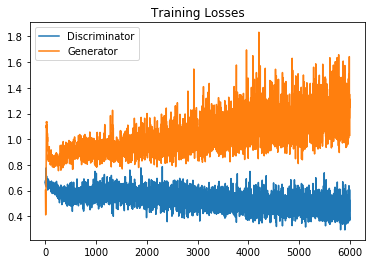

In [13]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

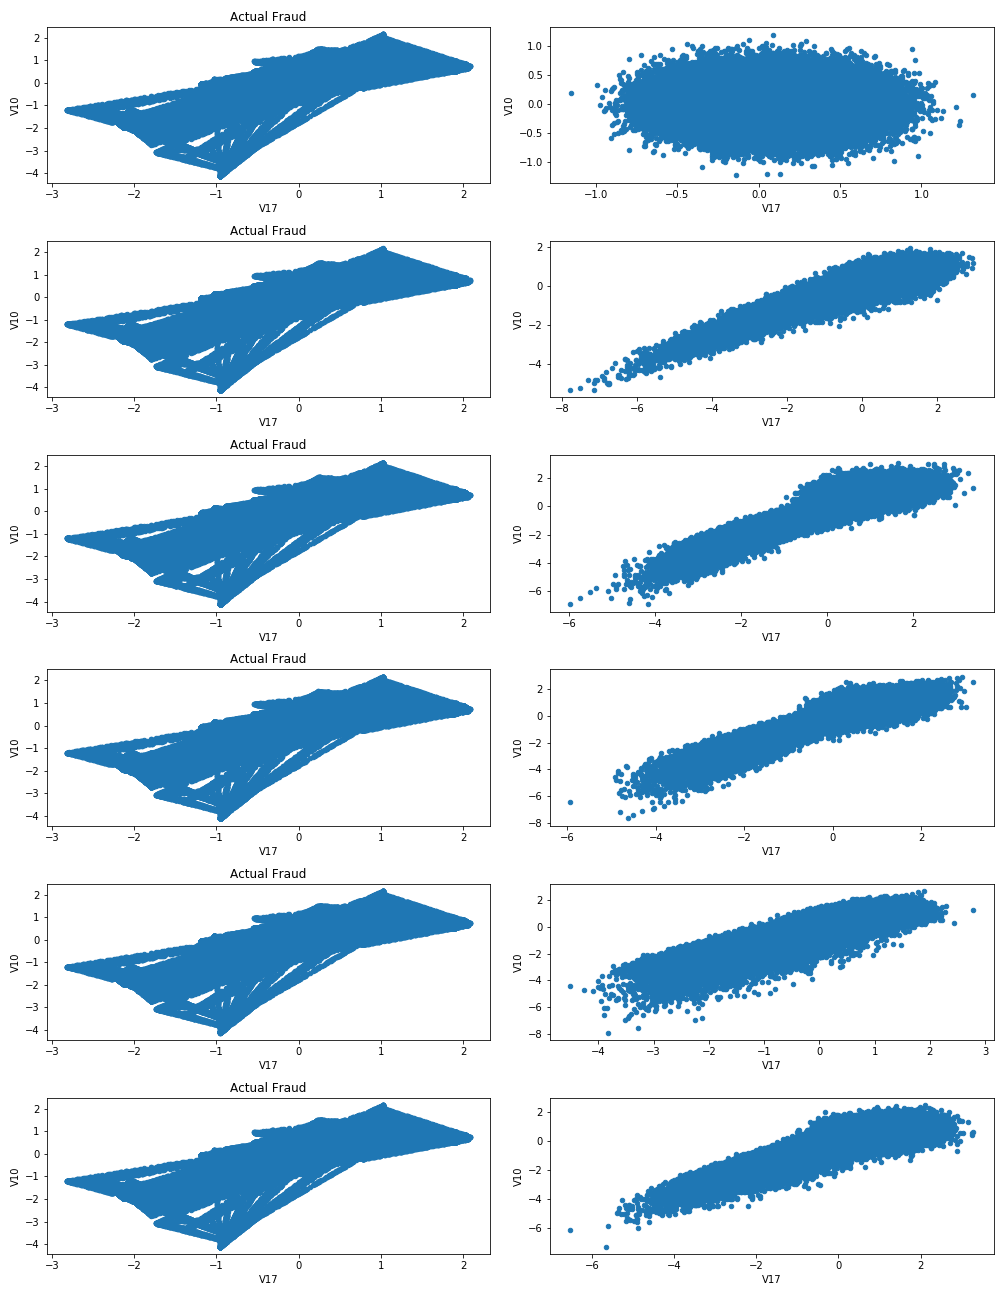

In [14]:
from IPython.display import Image
Image(filename='GANv1.4-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

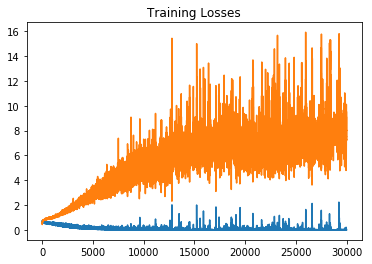

In [68]:
fig